In [1]:
pip install textattack

In [2]:
import numpy as np
import torch
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification, Trainer, TrainingArguments, pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from textattack.augmentation import EasyDataAugmenter

**Initialize NLTK and Spacy**

In [3]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
nlp = spacy.load("en_core_web_sm")
aug = EasyDataAugmenter()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Preprocess and augment the text data**

In [4]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

def augment_text(text):
    return aug.augment(text)[0]

In [5]:
texts = ["Financial regulation is crucial.", "Compliance with laws is mandatory.",
         "Financial audits ensure transparency.", "Regulators enforce legal standards."]
labels = [1, 1, 0, 0]

# Preprocess and augment the data
texts = [preprocess_text(text) for text in texts]
texts = [augment_text(text) for text in texts]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.25, random_state=42)

# Initialize Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Encode Texts
def encode_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

train_encodings = encode_texts(X_train)
test_encodings = encode_texts(X_test)

# Define a custom dataset class for PyTorch
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, y_train)
test_dataset = TextDataset(test_encodings, y_test)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**Initialize DistilBERT Model for Classification**

In [6]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-be9f9aba3a2a>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss


TrainOutput(global_step=3, training_loss=0.6974736849466959, metrics={'train_runtime': 14.6914, 'train_samples_per_second': 0.613, 'train_steps_per_second': 0.204, 'total_flos': 20956756428.0, 'train_loss': 0.6974736849466959, 'epoch': 3.0})

**Predict using the DistilBERT model**

DistilBERT Accuracy: 0.0

DistilBERT Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

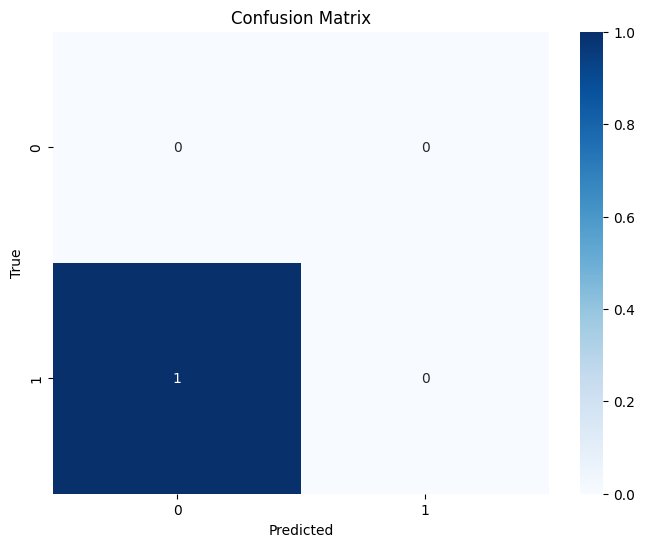

In [7]:
def predict_with_distilbert(texts):
    encodings = encode_texts(texts)
    with torch.no_grad():
        outputs = model(**encodings)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)[:, 1].tolist()
    return probabilities

test_predictions = predict_with_distilbert(X_test)
test_pred_labels = [1 if prob > 0.5 else 0 for prob in test_predictions]

print("DistilBERT Accuracy:", accuracy_score(y_test, test_pred_labels))
print("\nDistilBERT Classification Report:\n", classification_report(y_test, test_pred_labels))

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, test_pred_labels, labels=[0, 1])

**Traditional models for comparison**

In [8]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

**Logistic Regression**

Logistic Regression Accuracy: 0.0

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

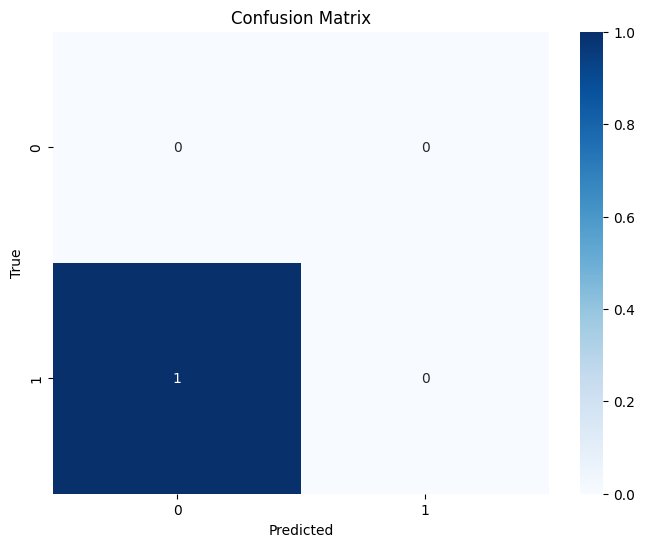

In [9]:
lr_model = LogisticRegression()
lr_model.fit(X_train_vec, y_train)
lr_predictions = lr_model.predict(X_test_vec)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_predictions))
plot_confusion_matrix(y_test, lr_predictions, labels=[0, 1])

**SVM**

SVM Accuracy: 0.0

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

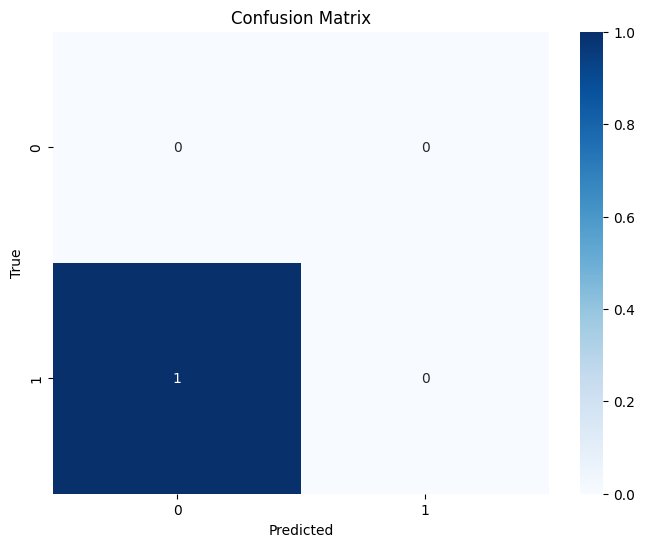

In [10]:
svm_model = SVC(probability=True)
svm_model.fit(X_train_vec, y_train)
svm_predictions = svm_model.predict(X_test_vec)

print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("\nSVM Classification Report:\n", classification_report(y_test, svm_predictions))
plot_confusion_matrix(y_test, svm_predictions, labels=[0, 1])

**ROC and Precision-Recall Curves**

In [11]:
def plot_roc_curve(y_true, y_scores, label):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='best')
    plt.show()

def plot_precision_recall_curve(y_true, y_scores, label):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure()
    plt.plot(recall, precision, label=f'{label}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

**DistilBERT Scores**

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


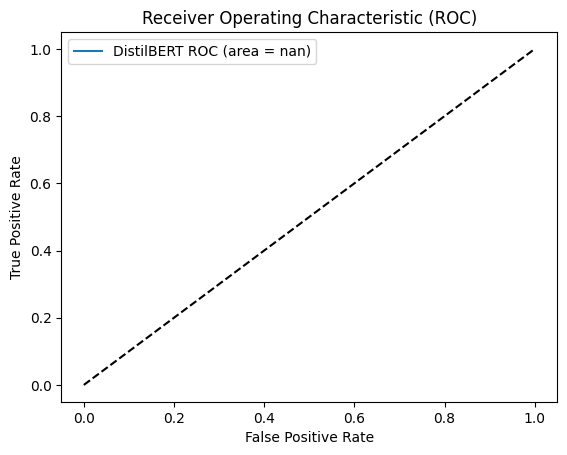

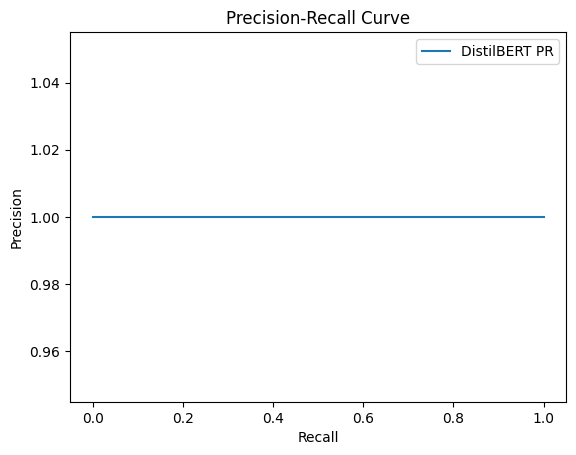

In [12]:
plot_roc_curve(y_test, test_predictions, 'DistilBERT ROC')
plot_precision_recall_curve(y_test, test_predictions, 'DistilBERT PR')

**Logistic Regression ROC and PR**

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


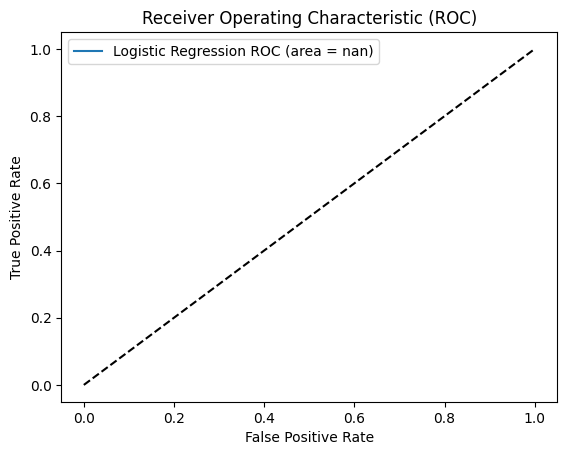

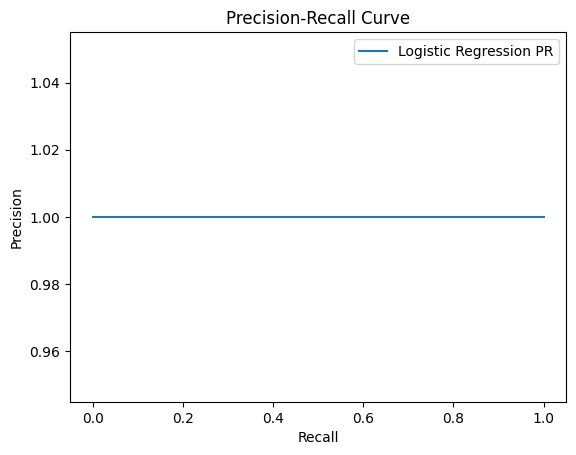

In [13]:
lr_proba = lr_model.predict_proba(X_test_vec)[:, 1]
plot_roc_curve(y_test, lr_proba, 'Logistic Regression ROC')
plot_precision_recall_curve(y_test, lr_proba, 'Logistic Regression PR')

**SVM ROC and PR**

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


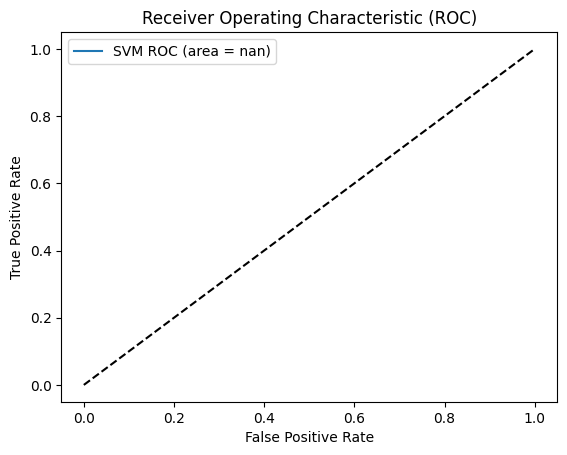

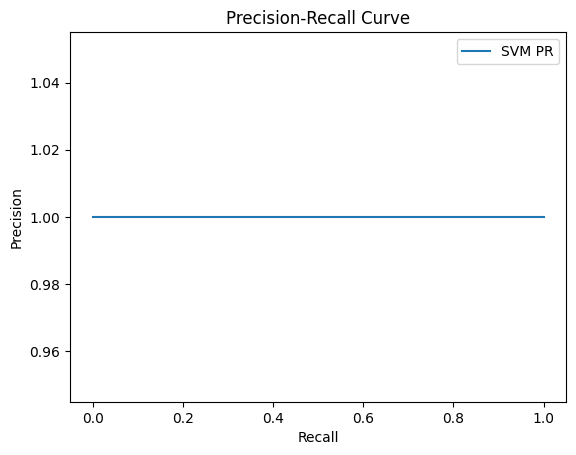

In [14]:
svm_proba = svm_model.predict_proba(X_test_vec)[:, 1]
plot_roc_curve(y_test, svm_proba, 'SVM ROC')
plot_precision_recall_curve(y_test, svm_proba, 'SVM PR')